In [0]:
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

class Helper(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = Helper.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations
        train_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms

    @staticmethod
    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    @staticmethod
    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std

    # First step
    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = Helper.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = Helper.get_test_transforms(mean, std)
        if test_transforms is None:
            test_transforms = Helper.get_test_transforms(mean, std)
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    def view_images(self, path='./data', num_of_images=60, display_log=True):
        # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
        print("The initial stastics:")
        train, test = self.get_train_test_data_set(path=path, display_log=True)
        train_data = train.train_data
        train_data = train.transform(train_data.numpy())

        print('Image data stastics')
        print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
        print(' - Tensor Shape:', train.train_data.size())
        print(' - min:', torch.min(train_data))
        print(' - max:', torch.max(train_data))
        print(' - mean:', torch.mean(train_data))
        print(' - std:', torch.std(train_data))
        print(' - var:', torch.var(train_data))

        train_loader, test_loader = self.get_data_loader(train, test, batch_size=128)
        dataiter = iter(train_loader)
        images, labels = dataiter.next()

        print(images.shape)
        print(labels.shape)

        plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
        print("")
        self.view_defined_images(images, num_of_images)


    def view_defined_images(self, images, num_of_images):
        figure = plt.figure()
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))


    # second step
    def train_test_model(self, model_obj, EPOCHS=20, batch_size=128, path='./data', optimizer=None, train_transforms=None, test_transforms=None):
        # Train and test our model
        device = Helper.get_device()
        model = model_obj.to(device)
        if optimizer is None:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path, train_transforms=train_transforms, test_transforms=test_transforms)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    @staticmethod
    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff

    def display_plot(self):
        try:
            fig, axs = plt.subplots(2,2,figsize=(15,10))
            axs[0, 0].plot(self.train_losses)
            axs[0, 0].set_title("Training Loss")
            axs[1, 0].plot(self.train_acc)
            axs[1, 0].set_title("Training Accuracy")
            axs[0, 1].plot(self.test_losses)
            axs[0, 1].set_title("Test Loss")
            axs[1, 1].plot(self.test_acc)
            axs[1, 1].set_title("Test Accuracy")
            print('Train loss: ',self.train_min_loss)
            print('Test loss: ',self.test_losses)
            print("Difference in loss : ", Helper.calculate_diff(self.train_min_loss, self.test_losses))
            print('Train Accuracy: ',self.train_max_acc)
            print('Test Accuracy: ',self.test_acc)
            print("Difference in Accuracy : ", Helper.calculate_diff(self.train_max_acc, self.test_acc))
            max_element = max(self.train_max_acc)
            print("Maximum Train accuracy : ",max_element)
            print("Test accuracy : ",max(self.test_acc))
        except Exception as e:
            print("First train the model")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            print(str(e))
            pass

In [0]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        p = 0.05
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 26, RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 24, RF=5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 22,  RF=7
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 22,  RF=7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF=8
                # OUTPUT BLOCK
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(),
        #     # nn.Dropout2d(p)
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 9, RF=10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16), RF=12
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 7, RF=14
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout2d(p)
        ) # output_size = 7, RF=18
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1, RF=30

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8, RF=30

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 22, 22]           1,296
       BatchNorm2d-8           [-1, 12, 22, 22]              24
              ReLU-9           [-1, 12, 22, 22]               0
           Conv2d-10           [-1, 12, 22, 22]             144
      BatchNorm2d-11           [-1, 12, 22, 22]              24
             ReLU-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.07279279828071594 Batch_id=937 Accuracy=89.53: 100%|██████████| 938/938 [00:14<00:00, 62.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9797/10000 (97.97%)

EPOCH: 2


Train Set: Train Loss=0.06675375252962112 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:15<00:00, 62.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Train Set: Train Loss=0.03062346577644348 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:15<00:00, 60.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9845/10000 (98.45%)

EPOCH: 4


Train Set: Train Loss=0.009872883558273315 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:14<00:00, 63.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Train Set: Train Loss=0.016279876232147217 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:14<00:00, 63.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Train Set: Train Loss=0.005090087652206421 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:14<00:00, 63.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Train Set: Train Loss=0.05121275782585144 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:14<00:00, 63.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Train Set: Train Loss=0.034058719873428345 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:14<00:00, 63.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Train Set: Train Loss=0.05687260627746582 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:14<00:00, 63.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Train Set: Train Loss=0.048510968685150146 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:14<00:00, 63.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


Train Set: Train Loss=0.0046535879373550415 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:14<00:00, 63.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Train Set: Train Loss=0.02361828088760376 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:14<00:00, 63.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9950/10000 (99.50%)

EPOCH: 13


Train Set: Train Loss=0.014323264360427856 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:14<00:00, 64.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Train Set: Train Loss=0.08445188403129578 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:15<00:00, 62.28it/s]



Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

Train loss:  [0.07279279828071594, 0.06675375252962112, 0.03062346577644348, 0.009872883558273315, 0.016279876232147217, 0.005090087652206421, 0.05121275782585144, 0.034058719873428345, 0.05687260627746582, 0.048510968685150146, 0.0046535879373550415, 0.02361828088760376, 0.014323264360427856, 0.08445188403129578]
Test loss:  [0.07787879683971405, 0.0390258985042572, 0.05188203489780426, 0.030096834564208984, 0.02755422043800354, 0.027831522083282472, 0.02434769859313965, 0.022830949449539183, 0.022739779376983644, 0.017922511100769044, 0.024596883153915405, 0.017711749124526978, 0.019957317876815796, 0.01873582663536072]
Difference in loss :  [-0.005085998558998106, 0.027727854025363922, -0.02125856912136078, -0.02022395100593567, -0.011274344205856324, -0.02274143443107605, 0.02686505923271179, 0.011227770423889161, 0.03413282690048218, 0.030588457584381102, -0.019943295216560363, 0.005906531763076782, -0.005634053516387

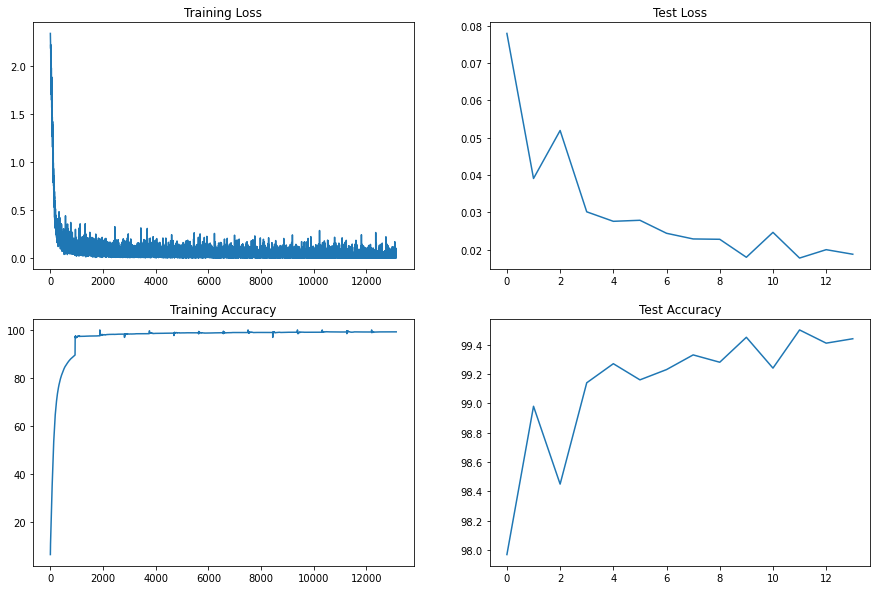

In [0]:
from torch.optim.lr_scheduler import StepLR
with Helper() as helper_obj:
  obj1 = Net5()
  device = helper_obj.get_device()
  helper_obj.display_summary(obj1, 28)
  #helper_obj.view_images()
  #update optimizer
  model =  obj1.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
  #apply image augumentaion
  train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-9.0, 9.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
  helper_obj.train_test_model(obj1, EPOCHS=14, batch_size=64, optimizer=optimizer, train_transforms=train_transforms)
  helper_obj.display_plot()